In [1]:
%matplotlib inline

from __future__ import unicode_literals
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython import display
from IPython.display import HTML, Image, clear_output

In [2]:
class PendulumEnv(gym.Env):
    
    #The state of the problem is defined by the four variables
    #(theta_1, theta_2, theta_1_dot, thetat_2_dot)
    
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 100
    }
    
    def __init__(self, m = 1, l = 1,
                 torque_levels = 3, max_torque = 1, 
                 delta_degree=30, time_step = 0.001):
        
        self.m = m
        self.l = l
        
        self.torque_levels = torque_levels
        self.delta = delta_degree * 2 * np.pi / 360
        self.time_step = time_step
        self.g = 9.8
        
        assert torque_levels % 2 == 1
        p=(torque_levels-1)/2
        
        
        #Defining the action space and observation space
        self.action_space = spaces.Discrete(torque_levels)
        self.act_torque_dict = {i:(i-p)*max_torque/p for i in range(torque_levels)}
        l_limits = np.array([       0, -100000])
        h_limits = np.array([ 2*np.pi,  100000])
        self.observation_space = spaces.Box(l_limits, h_limits, dtype=np.float32)
        
        #Setting the seed
        self.seed()
        
        self.viewer = None
        self.state = None
        self.odeint_engine = None
        self.exp_history=[]
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_differentials(self, all_vars = [0,0,0]):
        #All state variables should be inserted here:
        # all_vars = [theta_1, omega_1, input_torque]
        
        #Equations are used from the following link
        #http://wikis.controltheorypro.com/index.php?title=Inverted_pendulum
        
        theta = all_vars[0]
        omega_1 = all_vars[1]
        u = all_vars[2]
        
        l = self.l
        m = self.m
        g = self.g
        
        #Cosines and Sinuses
        c1 = np.cos(theta)
        s1 = np.sin(theta)
        
        acc = (-1 * g * s1 / l) + (u / (m * (l**2)))
        
        diff_all_vars = np.array([omega_1, acc, 0])
        return diff_all_vars    
        
    def reset(self):
        self.state = np.random.randn(2)
        self.state[0] = self.state[0] % (2 * np.pi)
        self.exp_history.append({'states':[], 'actions':[], 'rewards':[]})
        return np.array(self.state)
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        
        u = self.act_torque_dict[action]
        if self.odeint_engine is None:
            from scipy.integrate import ode
            f = lambda t,y: self.get_differentials(all_vars = y)
            self.odeint_engine = ode(f, jac=None).set_integrator('dopri5')
            self.dt = 0.001
            
        self.odeint_engine.set_initial_value(y=[self.state[0], self.state[1],  u], t=0)
        while self.odeint_engine.successful() and self.odeint_engine.t < self.time_step:
            self.odeint_engine.integrate(self.odeint_engine.t + self.dt)
        
        self.state = np.copy(self.odeint_engine.y[:-1])
        self.state[0] = self.state[0] % (2*np.pi)
        
        #print('u is: '+str(u))
        #T_1,T_2,U=self.get_energy()
        #print('Energy: ' + str(T_1+T_2+U))
    
        done=False
        if self.observation_space.contains(self.state):
            if (self.state[0] > np.pi-self.delta and self.state[0] < np.pi+self.delta) and \
               (self.state[1] < self.delta or self.state[1] > 2 * np.pi - self.delta):
                reward = 1
            else:
                reward = 0
        else:
            done = True
            reward = -1
        
        self.exp_history[-1]['states'].append(self.state)
        self.exp_history[-1]['actions'].append(action)
        self.exp_history[-1]['rewards'].append(reward)
        
        return self.state, reward, done, {}
    
    def render(self, mode='human'):
        screen_width = 100
        screen_height = 100
        
        length_scale = (min(screen_width, screen_height)*0.9) / (2*(self.l1 + self.l2))
        my_l1 = length_scale * self.l1
        my_l2 = length_scale * self.l2
        theta_1 = self.state[0]
        theta_2 = self.state[1]
        
        center = (screen_width/2 , screen_height/2)
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            
            l1end = (center[0] + my_l1 * np.sin(theta_1), center[1] + my_l1 * np.cos(theta_1))
            l2end = (l1end[0] + my_l2 * np.sin(theta_1 + theta_2), l1end[1] + my_l2 * np.cos(theta_1))
            self.leg1 = rendering.Line(start = center, end = l1end)
            self.leg2 = rendering.Line(start = l1end , end = l2end)
            
            self.leg1.attrs.pop()
            self.leg1.linewidth = rendering.LineWidth(3)
            self.leg1.add_attr(self.leg1.linewidth)
            self.leg1.set_color(0,0,0)
            self.viewer.add_geom(self.leg1)
            
            self.leg2.attrs.pop()
            self.leg2.linewidth = rendering.LineWidth(3)
            self.leg2.add_attr(self.leg2.linewidth)
            self.leg2.set_color(0,0,0)
            self.viewer.add_geom(self.leg2)
            
        #Drawing the point
        if self.state is None: return None
        
        l1end = (center[0] + my_l1 * np.sin(theta_1), center[1] - my_l1 * np.cos(theta_1))
        l2end = (l1end[0] + my_l2 * np.sin(theta_1 + theta_2), l1end[1] - my_l2 * np.cos(theta_1 + theta_2))
        self.leg1.start = center
        self.leg1.end = l1end
        self.leg2.start = l1end 
        self.leg2.end = l2end
        
        return self.viewer.render(return_rgb_array = mode=='rgb_array')
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
            
    def plt_render(self):
        
        all_states = self.exp_history[-1]['states']
        all_actions = self.exp_history[-1]['actions']
        all_rewards = self.exp_history[-1]['rewards']
        
        theta = [s[0] for _,s in enumerate(all_states)]
        omega = [s[1] for _,s in enumerate(all_states)]
        torques = [self.act_torque_dict[tau] for _,tau in enumerate(all_actions)]
        time_array = self.time_step * np.arange(len(theta))
        
        self.figure = plt.figure()
        self.figure.set_size_inches(12, 12, forward=True)
        
        self.act_ax = plt.subplot2grid((4, 4), (0, 0))
        self.theta_ax = plt.subplot2grid((4, 4), (0, 1))
        self.reward_ax = plt.subplot2grid((4, 4), (1, 0))
        self.omega_ax = plt.subplot2grid((4, 4), (1, 1))
        self.traj_ax = plt.subplot2grid((4, 4), (2, 0), colspan=2, rowspan=2)
        
        self.traj_ax.set_xlim([-(self.l)*1.05, (self.l)*1.05])
        self.traj_ax.set_ylim([-(self.l)*1.05, (self.l)*1.05])
        
        plot_ax_list = [self.act_ax, self.theta_ax,
                        self.reward_ax, self.omega_ax]
        plot_data_list = [torques, theta, all_rewards, omega]
        plot_title_list = [r'$\tau$', r'$\theta$',
                           r'$R$', r'$\omega$']
        
        
        for i,curr_ax in enumerate(plot_ax_list):
            curr_data=plot_data_list[i]
            curr_ax.set_xlim([0,time_array[-1]])
            if np.min(curr_data) == np.max(curr_data):
                curr_ax.set_ylim([np.min(curr_data) - 1, np.max(curr_data) + 1])
            else:
                curr_ax.set_ylim([1.05*np.min(curr_data),1.05*np.max(curr_data)])
            curr_ax.set_title(plot_title_list[i], fontsize=16)
        
        self.acrobot, = self.traj_ax.plot([], [], 'o-', lw=2)
        self.traj_ax.set_title('Trajectory', fontsize=16)
        
        self.plot_lines = []
        for i,curr_ax in enumerate(plot_ax_list):
            curr_line, = curr_ax.plot([], [], color='k')
            self.plot_lines.append(curr_line)

        def init():
            self.acrobot.set_data([], [])
            for curr_line in self.plot_lines:
                curr_line.set_data([], [])
            return self.acrobot, self.plot_lines[0], self.plot_lines[1], self.plot_lines[2], \
                    self.plot_lines[3]

        def animate(i):
            thisx = [0,  self.l * np.sin(theta[i])]
            thisy = [0, -self.l * np.cos(theta[i])]

            self.acrobot.set_data(thisx, thisy)
            
            for j,curr_line in enumerate(self.plot_lines):
                curr_data = plot_data_list[j]
                curr_line.set_data(time_array[:i], curr_data[:i])
            return self.acrobot, self.plot_lines[0], self.plot_lines[1], self.plot_lines[2], \
                    self.plot_lines[3]

        self.ani = animation.FuncAnimation(self.figure, animate, np.arange(len(theta)),
                                           interval=25, blit=True, init_func=init)

        #ani.save('./double_pendulum.gif', fps=15)
        #plt.show()

In [3]:
%matplotlib inline
env = PendulumEnv(m = 1, l = 1,
                  torque_levels = 3, max_torque = 5, 
                  delta_degree=30, time_step = 0.05)
try:
    for i_episode in range(1):
        observation = env.reset()
        for t in range(100):
            #env.render(mode = 'human')
            action = env.action_space.sample()
            action=1
            observation, reward, done, info = env.step(action)
            #print(observation, reward)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
    env.close()
except (KeyboardInterrupt, SystemExit):
    env.close()

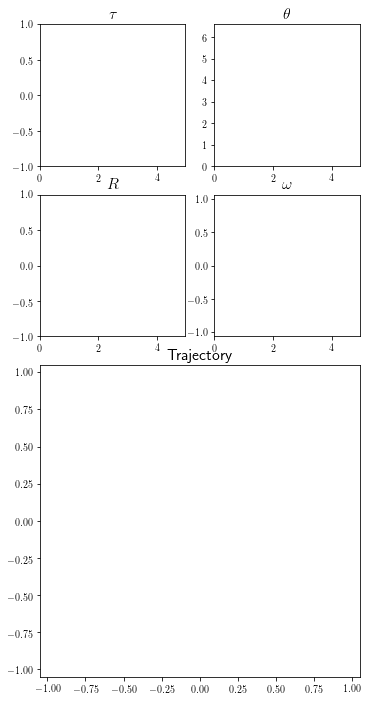

In [4]:
%matplotlib inline
env.plt_render()
clear_output(wait=True)

In [5]:
HTML(env.ani.to_jshtml(fps = 1.0/env.time_step))

In [7]:
#env.ani.save('./animation.mp4', writer='imagemagick', fps=20)
env.ani.save('./problem3.gif', writer=animation.PillowWriter(fps= 1.0/env.time_step))